In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

#import poppy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd
import datafiles as dfx

#import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [4]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm, # not really useful but okay
             'surf_units': u.micron}

folder_coat = 'zygo_data/oaps/oap_coated/'
coat_labels =  ('0', '1', '2', '3', '4', '5_sn1', '5_sn2', '5_sn3')
ntot = len(coat_labels)

oap=[]
flat_norm = np.zeros((ntot, opt_parms['ovs']*opt_parms['ovs']))
flat_var = np.zeros((ntot))
for n in range(0,ntot):
    # Write filename
    surf_data_loc = folder_coat+'oap{0}_centered_{1}CA'.format(coat_labels[n], str(opt_parms['ca']))
    if n < 5:
        n_oap = 'n{0}'.format(n)
    else:
        snum = (n - 5) + 1 # serial number
        n_oap = 'n5_sn{0}'.format(snum)
    
    # create the object
    t_oap = psd.surfPSD(surf_name = n_oap)
    
    # open the files
    t_oap.open_surf(fileloc=surf_data_loc+'_surf.fits', surf_units=opt_parms['surf_units'])
    t_oap.open_mask(fileloc=surf_data_loc+'_mask.fits')

    # calculate the PSD
    t_oap.calc_psd(oversamp = opt_parms['ovs'])
    if n==2:
        print('psd for {0} needs masking to eliminate sine wave blips'.format(n_oap))
        n2_mask_centers = [(3107, 1922), (990, 2175)]
        n2_radius = [28, 28]
        t_oap.mask_psd(n2_mask_centers, n2_radius)
    print('PSD for {0} complete'.format(n_oap))
    
    # calculate the radial profile
    t_oap.calc_psd_radial(ring_width=5)
    print('Radial profile for {0} complete\n'.format(n_oap))
    
    oap.append(t_oap)
    flat_norm[n] = t_oap.psd_norm.reshape(opt_parms['ovs']*opt_parms['ovs'])
    flat_var[n] = t_oap.var.value
    
print('All OAP PSD complete')

PSD for n0 complete
Radial profile for n0 complete

PSD for n1 complete
Radial profile for n1 complete

psd for n2 needs masking to eliminate sine wave blips
PSD for n2 complete
Radial profile for n2 complete

PSD for n3 complete
Radial profile for n3 complete

PSD for n4 complete
Radial profile for n4 complete

PSD for n5_sn1 complete
Radial profile for n5_sn1 complete

PSD for n5_sn2 complete
Radial profile for n5_sn2 complete

PSD for n5_sn3 complete
Radial profile for n5_sn3 complete

All OAP PSD complete
CPU times: user 5min 27s, sys: 1min 57s, total: 7min 25s
Wall time: 7min 12s


In [7]:
# calculate the average OAP PSD
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(opt_parms['ovs'], opt_parms['ovs'])*oap[0].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*oap[0].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by making its own object
avg_psd = psd.surfPSD(surf_name='oap_avg')
avg_psd.load_psd(psd_data=cal_psd_avg, psd_type='cal', var=var_avg)
avg_psd.load_psd_parameters(oversamp=oap[0].oversamp,
                            diam_ca=oap[0].diam_ca,
                            npix_diam=oap[0].npix_diam,
                            wavelen=oap[0].wavelen)
avg_psd.calc_rms_set(kmid_ll=0.1/u.mm, khigh_ll=1/u.mm, pwr_opt=avg_psd.psd_cal)
avg_psd.write_psd_file(filename=folder_coat+'oap_avgPSD_centered_{0}CA'.format(str(opt_parms['ca'])),
                       psd_data = avg_psd.psd_cal,
                      single_precision=False)
avg_psd.calc_psd_radial(ring_width=5)
print('PSD and radial profile for all dust masked in averaged surface complete.')

PSD and radial profile for all dust masked in averaged surface complete.


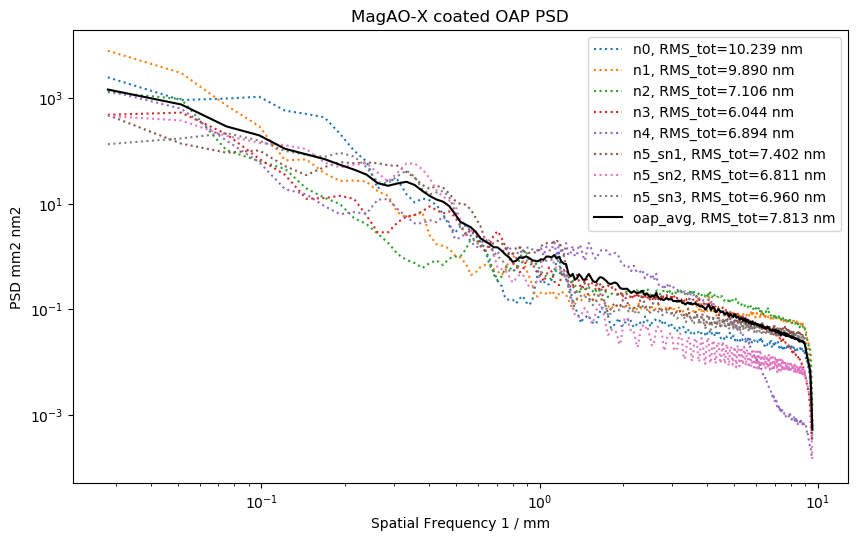

In [12]:
plt.figure(figsize=[10,6],dpi=100)
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_tot={1:.3f}'.format(obj.surf_name, obj.rms_tot))
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_tot={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_tot))
plt.xlabel('Spatial Frequency {0}'.format(oap[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(oap[0].psd_radial_cal.unit))
plt.title('MagAO-X coated OAP PSD')
plt.legend()
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
# special lines
tweeter_diam = 18.8 * u.mm
k_bmc2k = 1/tweeter_diam
nact_tweeter = 24
M1_radius = 3.25 * u.m
tweeter_BW = nact_tweeter / ((M1_radius*2).to(u.mm))

surf_rough = (1*u.nm).to(u.mm)

### Calculate the RMS at low, mid, high spatial frequency bands.
Verify that manufacturer met specs.

In [8]:
# Evaluate the rms at low, mid, high spatial frequency 
klow_min = 1/(40*u.mm)
klow_max = 1/(10*u.mm)
klow_rms_target = 7.5*u.nm

kmid_min = 1/(10*u.mm)
kmid_max = 1/(1*u.mm)
kmid_rms_target = 10.2*u.nm

khigh_min = 1/(1*u.mm)
khigh_max = 1/(0.085*u.mm)
khigh_rms_target = 5.2*u.nm

klrms = []
kmrms = []
khrms = []
for obj in oap: 
    klrms.append(obj.calc_psd_rms(obj.psd_cal, klow_min, klow_max))
    kmrms.append(obj.calc_psd_rms(obj.psd_cal, kmid_min, kmid_max))
    khrms.append(obj.calc_psd_rms(obj.psd_cal, khigh_min, khigh_max))

print('RMS calculations')
print('{0:>7} | {1:^9.4} | {2:^10.4} | {3:^9.4}'.format('optic', 'low', 'mid', 'high'))
print('{0:>7} | {1:.4f} | {2:2.4f} | {3:.4f}'.format('tgt', klow_rms_target, kmid_rms_target, khigh_rms_target))
for no in range(0, ntot):
    print('{0:>7} | {1:.4f} | {2:7.4f} | {3:.4f}'.format(oap[no].surf_name, klrms[no], kmrms[no], khrms[no]))

RMS calculations
  optic |    low    |    mid     |   high   
    tgt | 7.5000 nm | 10.2000 nm | 5.2000 nm
     n0 | 5.7777 nm |  7.8189 nm | 2.8146 nm
     n1 | 7.9845 nm |  3.4592 nm | 4.4178 nm
     n2 | 3.7554 nm |  2.3411 nm | 5.3397 nm
     n3 | 2.9967 nm |  3.1623 nm | 4.1974 nm
     n4 | 3.5258 nm |  2.9501 nm | 5.0626 nm
 n5_sn1 | 2.1287 nm |  5.7195 nm | 4.1451 nm
 n5_sn2 | 2.7982 nm |  5.7845 nm | 2.2516 nm
 n5_sn3 | 2.3126 nm |  5.4236 nm | 3.6668 nm


### Model the PSD
Base the model on the average PSD

In [9]:
# solve for the LSF values of alpha and beta
# cut off the high frequency slump at the end
k_range = oap[0].k_radial[np.log10(oap[0].k_radial.value)<0.95] # in log scale, this is the cutoff
avg_cpsd = avg_psd_cal[0:len(k_range)]
la, lb = psd.solve_model_lsf(avg_cpsd, k_range)

# calculate average surface roughness rms
sr_rms = [0.51, 0.54, 1.00, 0.59, 0.5, 0.41, 0.44, 0.43] * u.nm
avg_sr_rms = np.mean(sr_rms)
bsr = psd.calc_bsr(rms_sr = avg_sr_rms, k_min = oap[0].k_min, k_max = oap[0].k_max)
bsr
# all OAPs sampled same, so have same k_min and k_max

/home/jhen/XWCL/code/MagAOX/functions/psd_functions.py:237: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A, y)[0] # y = mx + c linear equation


<Quantity 0.00105786 mm2 nm2>

In [10]:
# Expand spatial freq range to see where the model takes us with the data

# concatenate array for front
last = np.min(k_range) - oap[0].delta_k # initialize
front_fill = []
while last.value>0:
    front_fill.append(last.value)
    last = last - oap[0].delta_k
front_k = np.hstack((np.asarray(front_fill[::-1]), np.asarray(oap[0].k_radial.value)))

# concatenate array for end
nex_pts = 800
dkr = (oap[0].k_radial[1] - oap[0].k_radial[0]).value
dkr_mult = 3
rear_fill = [(np.amax(oap[0].k_radial.value) + (dkr*dkr_mult))]
for i in range(1, nex_pts): rear_fill.append(rear_fill[i-1] + (dkr*dkr_mult))
new_k = np.hstack((front_k, np.asarray(rear_fill)))*oap[0].k_radial.unit
    
#verify it all went together, should end up as 0
# np.shape(new_k)[0] - len(front_fill) - len(rear_fill) - len(oap[0].k_radial)
new_k

<Quantity [4.67966642e-03, 9.35933285e-03, 1.40389993e-02, ...,
           6.55668063e+01, 6.56370013e+01, 6.57071963e+01] 1 / mm>

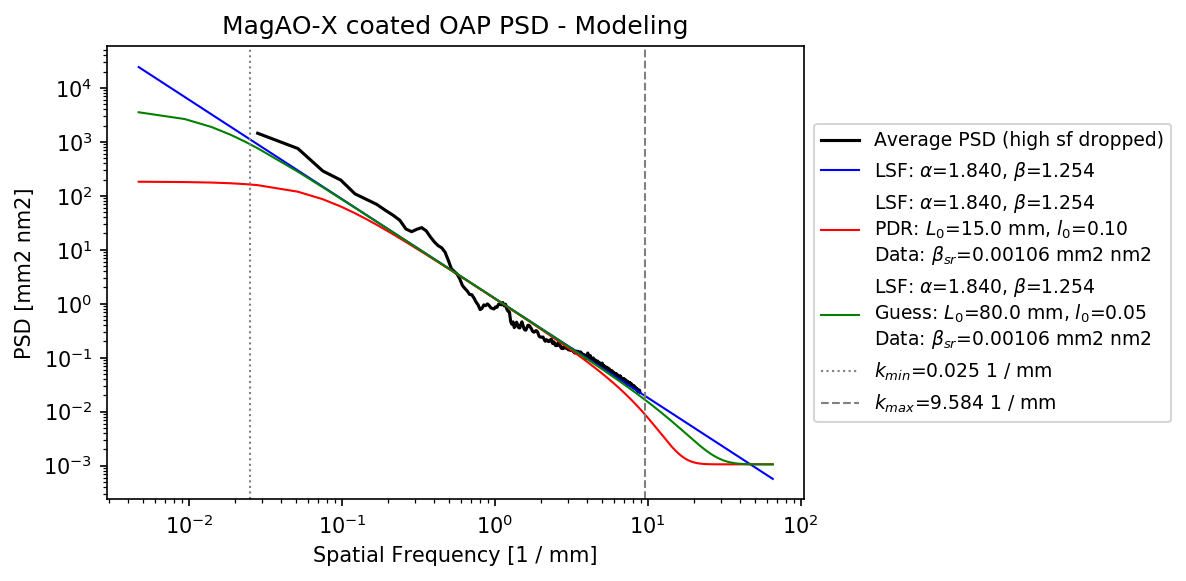

In [11]:
# extend k-range for LSF
p_lsf_ext = psd.calc_model_simple(new_k, la, lb)

# PDR L's
lo = 0.1
L0 = 15*u.mm
p_full = psd.calc_model_full(new_k, la, lb, L0, lo, bsr)

# guessing the L's
g_lo = 0.05
g_L0 = 80*u.mm
p_full_guess = psd.calc_model_full(new_k, la, lb, g_L0, g_lo, bsr)

# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
bsr

<Quantity 0.00105786 mm2 nm2>

In [21]:
from scipy.optimize import curve_fit
def model_lo_L0(k, alpha, beta, lo, L0, bsr):
    #return ((beta*np.exp(-(k*lo)**2)) / ( ((L0**-2) + (k**2))**(alpha/2) )) + bsr
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

def model_lo(k, lo):
    # hard-coded from past calculations
    alpha = 1.8395337855459057 # linear LSF
    beta = 1.2542724 # linear LSF
    bsr = 0.0010578594 # calculated from data
    return (beta*np.exp(-(k*lo)**2)/(k**alpha)) + bsr

popt, pcov = curve_fit(model_lo, k_range.value, avg_cpsd.value)
popt

array([-5.45857637e-06])

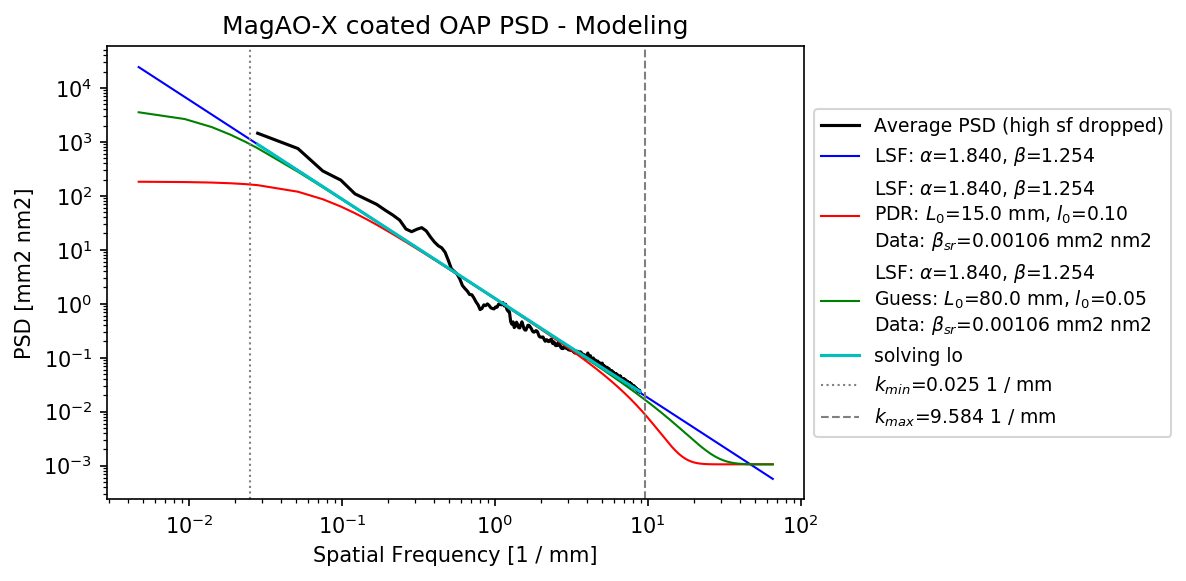

In [22]:
psd_lo = model_lo(k=k_range.value,lo=popt[0])
# check the plots
plt.figure(dpi=150)
plt.loglog(k_range, avg_cpsd, 'k', linewidth=1.5, label='Average PSD (high sf dropped)')
plt.loglog(new_k, p_lsf_ext, 'b', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}'.format(r'$\alpha$', la, r'$\beta$', lb.value))
plt.loglog(new_k, p_full, 'r', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nPDR: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$',L0, 
                                                                         r'$l_{0}$', lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(new_k, p_full_guess, 'g', linewidth=1,
           label='LSF: {0}={1:.3f}, {2}={3:.3f}\nGuess: {4}={5}, {6}={7:.2f}\nData: {8}={9:.5f}'.format(r'$\alpha$', la, 
                                                                         r'$\beta$', lb.value, 
                                                                         r'$L_{0}$', g_L0, 
                                                                         r'$l_{0}$', g_lo,
                                                                         r'$\beta_{sr}$', bsr))
plt.loglog(k_range, psd_lo, 'c', label='solving lo')
plt.axvline(x=oap[0].k_min.value, color='grey', ls=':', label='{0}={1:.3f}'.format(r'$k_{min}$', oap[0].k_min), linewidth=1)
plt.axvline(x=oap[0].k_max.value, color='grey', ls='--', label='{0}={1:.3f}'.format(r'$k_{max}$', oap[0].k_max), linewidth=1)
plt.xlabel('Spatial Frequency [{0}]'.format(oap[0].k_radial.unit))
plt.ylabel('PSD [{0}]'.format(avg_psd_cal.unit))
plt.title('MagAO-X coated OAP PSD - Modeling')
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))